According to a [Stack Overflow Post](https://stackoverflow.com/a/34350553) it is possible ot use an AutoEncoder to compress the output of Word2Vec or RNNs down to smaller dimensions. Conversely, it is not realy feasible to try and implement a generative network directly using a Variational AutoEncoder (VAE).

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# pip install spacy-universal-sentence-encoder
import spacy_universal_sentence_encoder
nlp = spacy_universal_sentence_encoder.load_model('en_use_lg')

from functools import reduce
from tqdm import tqdm
import gensim
import gensim.corpora as corpora

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from Preprocessing import Preprocessor
preprocessor = Preprocessor(0)
tqdm.pandas()

# import necessary libraries
import tensorflow_hub as hub
  
# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [2]:
# limit = 2000
# limit = -1 # cannot do as it crashes
limit = 5000

In [3]:
df = pd.read_csv("khan_joined.csv")
target = 'topic'
df.head()

,course,unit,lesson,video_title,about,transcript,topic,transcript_cleaned,transcript_n_entries,tokens
0,computer,Intro to JS: Drawing & Animation,Intro to programming,What is Programming?,Programming is the process of creating a set o...,"Hi, welcome to programming! If you've never le...",Computing,"['Angry Birds', 'and of course', 'were giving ...",183,"['hi,', 'welcome', 'programming!', 'never', 'l..."
1,computer,Intro to JS: Drawing & Animation,Coloring,The Power of the Docs,Created by Pamela Fox.,Voiceover: Ok so you've\r\nmade a few programs...,Computing,"['because 1 degree to 270 degrees,\r\nthats wh...",542,"['voiceover:', 'ok', 'made', 'programs,', 'mig..."
2,computer,Intro to HTML/CSS: Making webpages,Further learning,HTML validation,Learn how to validate your webpages with the W...,"- [Voiceover] On Khan Academy, we pop up the o...",Computing,['this is a classic thing to forget is that al...,172,"['-', 'khan', 'academy,', 'pop', 'oh', 'noes',..."
3,computer,Intro to SQL: Querying and managing data,SQL basics,Welcome to SQL,SQL is useful for creating and querying relati...,- [Instructor] The world is full of data. Ever...,Computing,['just by mapping user IDs to badge IDs. Thats...,203,"['-', 'world', 'full', 'data.', 'every', 'app'..."
4,computer,Intro to SQL: Querying and managing data,SQL basics,S-Q-L or SEQUEL?,How is it pronounced? Why? Let's discuss...,"At this point, you've probably heard me\r\npro...",Computing,"['At this point', 'by pronouncing SQL the long...",129,"['point,', 'probably', 'heard', 'pronounce', '..."


In [4]:
# targets = df[target][0:limit]
data = df['transcript_cleaned'].sample(n=limit, random_state=42).reset_index(drop=True)
data.head()

0    ['and youll\r\nactually see isopropyl a little...
1    ['so hopefully\r\nthis was a good review for y...
2    ['- Instructor In other videos', 'there was li...
3    ['this was\r\njust the numerator. So this look...
4    ['or at any time\r\nwhile Im working through i...
Name: transcript_cleaned, dtype: object

## Translate words to numerics
### Preliminary Research
[Link to article about Word2Vec and GloVe](https://forecast.global/insight/numerical-interpretation-of-textual-data-understanding-vector-representations/). More on encodings from [medium](https://medium.com/@kashyapkathrani/all-about-embeddings-829c8ff0bf5b).  


Word Embeddings are a possible option. BOW method would give a fixed length vector. Word2Vec also works for this, though it assumes a skip-gram model. GloVe uses a Continuous Bag of Words (CBOW) to do this instead. Does not work with words not seen during training. FastText extension should be able to as it breaks words into tri-grams.

Sentence embeddings better preserve context when compared to word embeddings. ELMo, InferSent, and Sentence-BERT all work in this case.

Can test sentence embeddings using SentEval tool-kit.

### Ideas
Try both Word embeddings and one of the sentence embeddings later. Using Word2Vec over Glove as we want to train our own Corpus.

### Sentence Embeddings
Ended up stumbling across a [SpaCy package]((https://spacy.io/universe/project/spacy-universal-sentence-encoder)) that used google's Universal Sentence Encoder model. This takes text and translates into a [512 dimensional vector](https://amitness.com/2020/06/universal-sentence-encoder/).

In [5]:
d1 = nlp(data[0])
d2 = nlp(data[1])
d1.similarity(d2)

0.6806343918438431

We have now verified that the sentence embedder works. Now we need to create a list of all sentences for each target domain.

In [6]:
joined = df[[target, 'transcript']].sample(n=limit, random_state=42).reset_index(drop=True)
# joined['full_transcript'] = joined['transcript_cleaned']
# joined = joined.drop(columns=['transcript_cleaned'])
joined.head()

,topic,transcript
0,Science,- [Instructor] Let's try\r\nto name this molec...
1,Math,i've already made a handful\r\nof videos that ...
2,Humanities,"- [Instructor] In other videos, we've discusse..."
3,Math,I think now is as good a time as\r\nany to pla...
4,Math,- [Instructor] So we're told that f(x) is equa...


first off is that we notice the transcript has unicode characters and lots of weird tags. This is usually cleaned in the preprocessing pipeline so lets call that with different arguments.

In [7]:
joined['full_transcript'] = joined['transcript'].progress_apply(lambda x: preprocessor.clean(x))
joined.head()

100%|██████████| 5000/5000 [07:50<00:00, 10.63it/s]


,topic,transcript,full_transcript
0,Science,- [Instructor] Let's try\r\nto name this molec...,"(-, let, us, try, name, molecule, right, here,..."
1,Math,i've already made a handful\r\nof videos that ...,"(already, made, handful, videos, covers, going..."
2,Humanities,"- [Instructor] In other videos, we've discusse...","(-, videos, ,, discussed, causes, effects, wes..."
3,Math,I think now is as good a time as\r\nany to pla...,"(think, good, time, play, around, little, bit,..."
4,Math,- [Instructor] So we're told that f(x) is equa...,"(-, told, f(x, ), equal, infinite, series, ,, ..."


In [8]:
type(joined['full_transcript'][0])

spacy.tokens.doc.Doc

We now have the SpaCy doc for every transcript in our dataset. Next is to use this to break things out by sentences

In [9]:
joined['sents'] = joined['full_transcript'].progress_apply(lambda x: list(x.sents))
joined.head()

100%|██████████| 5000/5000 [00:00<00:00, 7431.58it/s] 


,topic,transcript,full_transcript,sents
0,Science,- [Instructor] Let's try\r\nto name this molec...,"(-, let, us, try, name, molecule, right, here,...","[(-, let, us, try, name, molecule, right, here..."
1,Math,i've already made a handful\r\nof videos that ...,"(already, made, handful, videos, covers, going...","[(already, made, handful, videos, covers, goin..."
2,Humanities,"- [Instructor] In other videos, we've discusse...","(-, videos, ,, discussed, causes, effects, wes...","[(-, videos, ,, discussed, causes, effects, we..."
3,Math,I think now is as good a time as\r\nany to pla...,"(think, good, time, play, around, little, bit,...","[(think, good, time, play, around, little, bit..."
4,Math,- [Instructor] So we're told that f(x) is equa...,"(-, told, f(x, ), equal, infinite, series, ,, ...","[(-, told, f(x, ), equal, infinite, series, ,,..."


In [10]:
type(joined['sents'][0])

list

In [11]:
keys = joined[target].unique()
result = []
for key in tqdm(keys):
    temp_df = joined[joined[target]==key]['sents']
    output = []
    for sentences in temp_df:
        for sentence in sentences:
            result.append({"label": key, "sent": str(sentence)})
        # output += encoding
        # output = np.concatenate((output, encoding), axis=0, out=None) # DO NOT USE NUMPY >>> MAY BREAK ENCODINGS
    # result.append((key, output))
result = pd.DataFrame(result)
result.head()

100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


,label,sent
0,Science,- let us try name molecule right here.
1,Science,first thing want identify longest chain carbons.
2,Science,"let us see, could one, two, three, four, five,..."
3,Science,"or, let us see, maybe one, two, three, four, f..."
4,Science,"yes, indeed, longest chain."


we now have the sentences for each doc. Next step is to encode each of them with the universal encoder

https://www.geeksforgeeks.org/word-embedding-using-universal-sentence-encoder-in-python/

In [12]:
labels = result['label']
sents = result['sent']
embeddings = embed(sents)
print(embeddings.shape)
print(embeddings[0].shape)

(355320, 512)
(512,)


we now have a label, a sentence, and an embedding for each sentence. We can now discard the sentences themselves and work just with the labels and embeddings.

In [13]:
y = labels
x = embeddings


pca = PCA(n_components=3)
pca_result = pca.fit_transform(x)

# result = pd.DataFrame()
result['pca-one'] = pca_result[:,0]
result['pca-two'] = pca_result[:,1] 
result['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
result.head(1)

Explained variation per principal component: [0.03361511 0.02688834 0.02194955]


,label,sent,pca-one,pca-two,pca-three
0,Science,- let us try name molecule right here.,-0.12615,-0.057749,0.072741


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

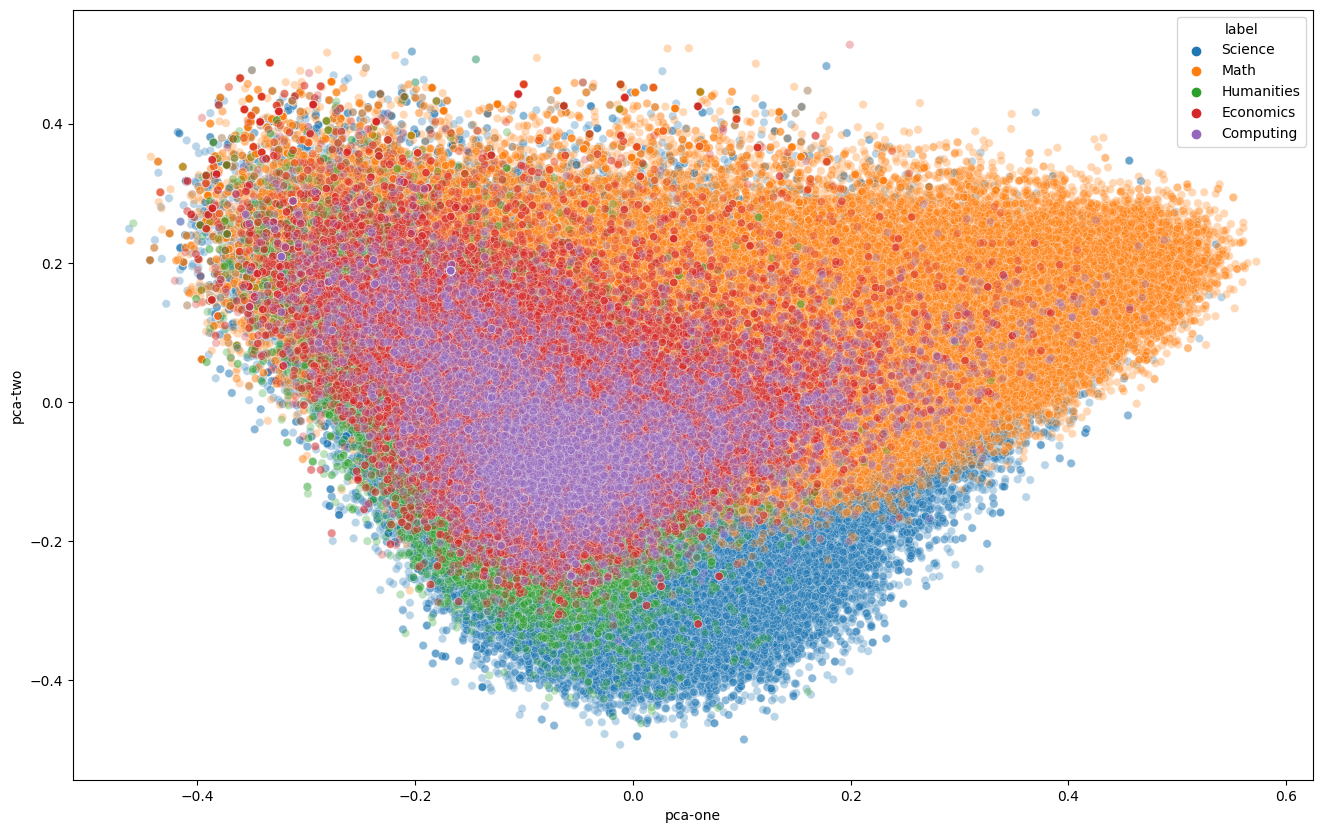

In [14]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=result["pca-one"], y=result["pca-two"],
    hue=result["label"],
    legend="full",
    alpha=0.3
)

In [15]:
unq = list(result['label'].unique())
lst = []
for element in result['label']:
    lst.append(unq.index(element))
result['y'] = lst

C:\Users\fassg\AppData\Local\Temp\ipykernel_24920\1110257658.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


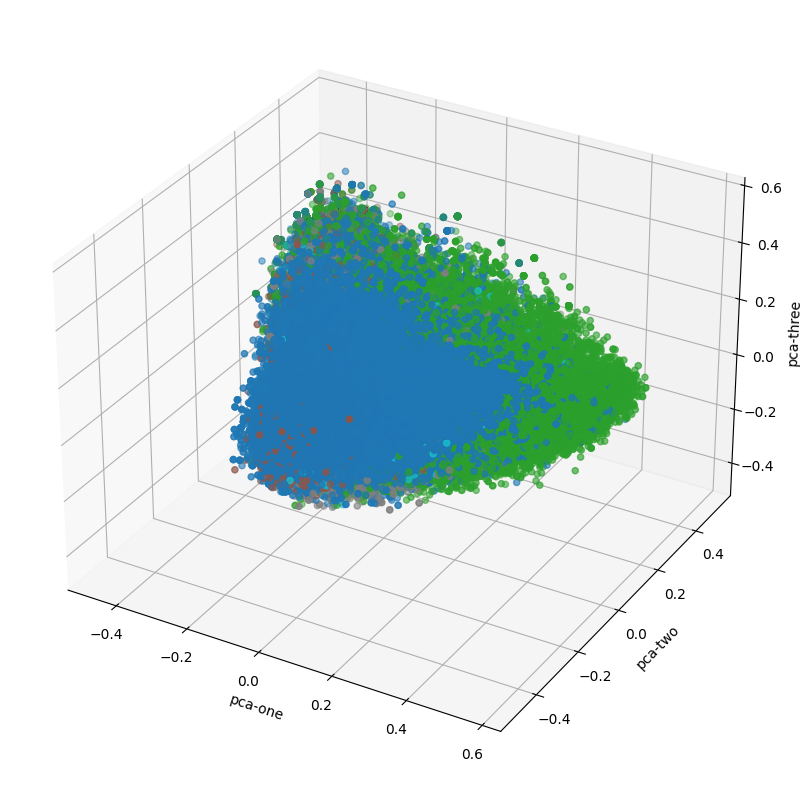

In [16]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    data=result,
    xs="pca-one", 
    ys="pca-two", 
    zs="pca-three", 
    c="y", 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

Try to train a model.

In [17]:
X = result.drop(columns=['label', 'sent'])
y = result['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [19]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)
print("ROC_AUC: %.2f" % (roc_auc_score(y_test, y_pred_prob, multi_class='ovo')))
print("F1: %.2f" % (f1_score(y_test, y_pred, average='weighted')))
print("Accuracy: %.2f" % (accuracy_score(y_test, y_pred)))
print("Precision: %.2f" % (precision_score(y_test, y_pred, average='weighted', zero_division=0)))
print("Recall: %.2f" % (recall_score(y_test, y_pred, average='weighted')))
print("------------------------------------")

ROC_AUC: 0.85
F1: 0.78
Accuracy: 0.84
Precision: 0.74
Recall: 0.84
------------------------------------


## Next Step
The next step would be to attempt to improve the performance of the model by using a graphical representation of the nodes. Unfortunately, I am currently stuck at this part. One of the key challenges with this step is that you need to identify some method of which to relate nodes to eachother. The nodes that we are working with represent indidividual sentences. This means that we would need to look for things that tie sentences together. This may include creating edges for sentences before and after the current one in the document. Edges for the closest sentence in another document. Edges for sentence with the closest number of vowels, words, or syllables. These are just possible ideas for sentences. I do not have the processing power or the time to pursue these though. Once the nodes were connected with the edges we could try to form the adjacency matrix then train a model on that. The thought would be tht by adding the positional and context information present in the edges to the model that our accuracy would significantly improve.

One thought of note is that because our dataset has so few target keywords (5 for subject and ~20 for course) we already have a good accuracy when just using a random forest classifier. Considering one of the goals of this would be to deploy it in a application it does not make sense to just attempt to make the model much more complex for a very marginal performance benefit.